In [34]:
import pandas as pd
import numpy as np

In [35]:
df_migrations = pd.read_csv('origin_x_destination_migrations.csv')

In [36]:
df_migrations

Region, development group, country or area of destination  \
0                                                Burundi          
1                                                Burundi          
2                                                Burundi          
3                                                Burundi          
4                                                Burundi          
...                                                  ...          
11817                          Wallis and Futuna Islands          
11818                          Wallis and Futuna Islands          
11819                          Wallis and Futuna Islands          
11820                          Wallis and Futuna Islands          
11821                          Wallis and Futuna Islands          

       Notes of destination  Location code of destination  \
0                       NaN                           108   
1                       NaN                           108   
2                       NaN                           108   
3                       NaN                           108   
4                       NaN                           108   
...                     ...                           ...   
11817                  41.0                           876   
11818                  41.0                           876   
11819                  41.0                           876   
11820                  41.0                           876   
11821                  41.0                           876   

      Type of data of destination  \
0                             B R   
1                             B R   
2                             B R   
3                             B R   
4                             B R   
...                           ...   
11817                         B R   
11818                         B R   
11819                         B R   
11820                         B R   
11821                         B R   

      Region, development group, country or area of origin  \
0                                                Belgium     
1                       Democratic Republic of the Congo     
2                                                 France     
3                                                  Kenya     
4                                                 Rwanda     
...                                                  ...     
11817                                             France     
11818                                   French Polynesia     
11819                                            Mayotte     
11820                                      New Caledonia     
11821                                            Vanuatu     

       Location code of origin    1990    1995   2000   2005    2010    2015  \
0                           56     642     621    475    466     497     605   
1                          180   36654   41447  37951  99099  147611  175768   
2                          250     321     310    237    232     248     302   
3                          404     186     216    202    502     847    1032   
4                          646  221943  160197  66415  61104   54794   64363   
...                        ...     ...     ...    ...    ...     ...     ...   
11817                      250     327     461    545    646     795     877   
11818                      258      18      23     28     32      19      15   
11819                      175      35      44     52     58      41      38   
11820                      540     843     975   1152   1207    1093    1021   
11821                      548     152     165    195    197     138      72   

         2020  
0         718  
1      199585  
2         358  
3        1226  
4       76567  
...       ...  
11817     889  
11818      10  
11819      27  
11820    1021  
11821      67  

[11822 rows x 13 columns]

In [37]:
year = '2015'

In [38]:
destination_label = 'Region, development group, country or area of destination'
origin_label = 'Region, development group, country or area of origin'

In [39]:
group_by_origin = df_migrations.groupby([origin_label])

In [40]:
df_migrations_weight = pd.DataFrame(data={'origin': [], 'destination': [], 'weight': []})

for name, group in group_by_origin:
    migrants_sum = group[year].sum()
    net_migrations = df_migrations.loc[df_migrations[destination_label] == name][year].sum() - migrants_sum
    
    if(net_migrations > 0):
        migrants_sum = migrants_sum + net_migrations
        new_row = pd.DataFrame({
            'origin': name, 
            'destination': name, 
            'weight': net_migrations/migrants_sum
        }, index=[0])
        df_migrations_weight = pd.concat([new_row, df_migrations_weight.loc[:]]).reset_index(drop=True)
    
    migrants_count_list.append(migrants_sum)
    
    for index, row in group.iterrows():
        new_row = pd.DataFrame({
            'origin': name, 
            'destination': row[destination_label], 
            'weight': row[year]/migrants_sum
        }, index=[0])
        df_migrations_weight = pd.concat([new_row, df_migrations_weight.loc[:]]).reset_index(drop=True)

df_migrations_weight.sort_values(by=['weight'], ascending=False)

origin                       destination    weight
180    Wallis and Futuna Islands                     New Caledonia  0.995546
4045                        Oman                              Oman  0.987199
3425                       Qatar                             Qatar  0.985756
905         United Arab Emirates              United Arab Emirates  0.976997
5001                      Mexico          United States of America  0.976739
...                          ...                               ...       ...
11680                    Andorra  Bolivia (Plurinational State of)  0.000000
8483           Equatorial Guinea                        Luxembourg  0.000000
11160                 Azerbaijan                        Luxembourg  0.000000
4011                        Oman                        Luxembourg  0.000000
6192                      Jordan                        Luxembourg  0.000000

[11915 rows x 3 columns]

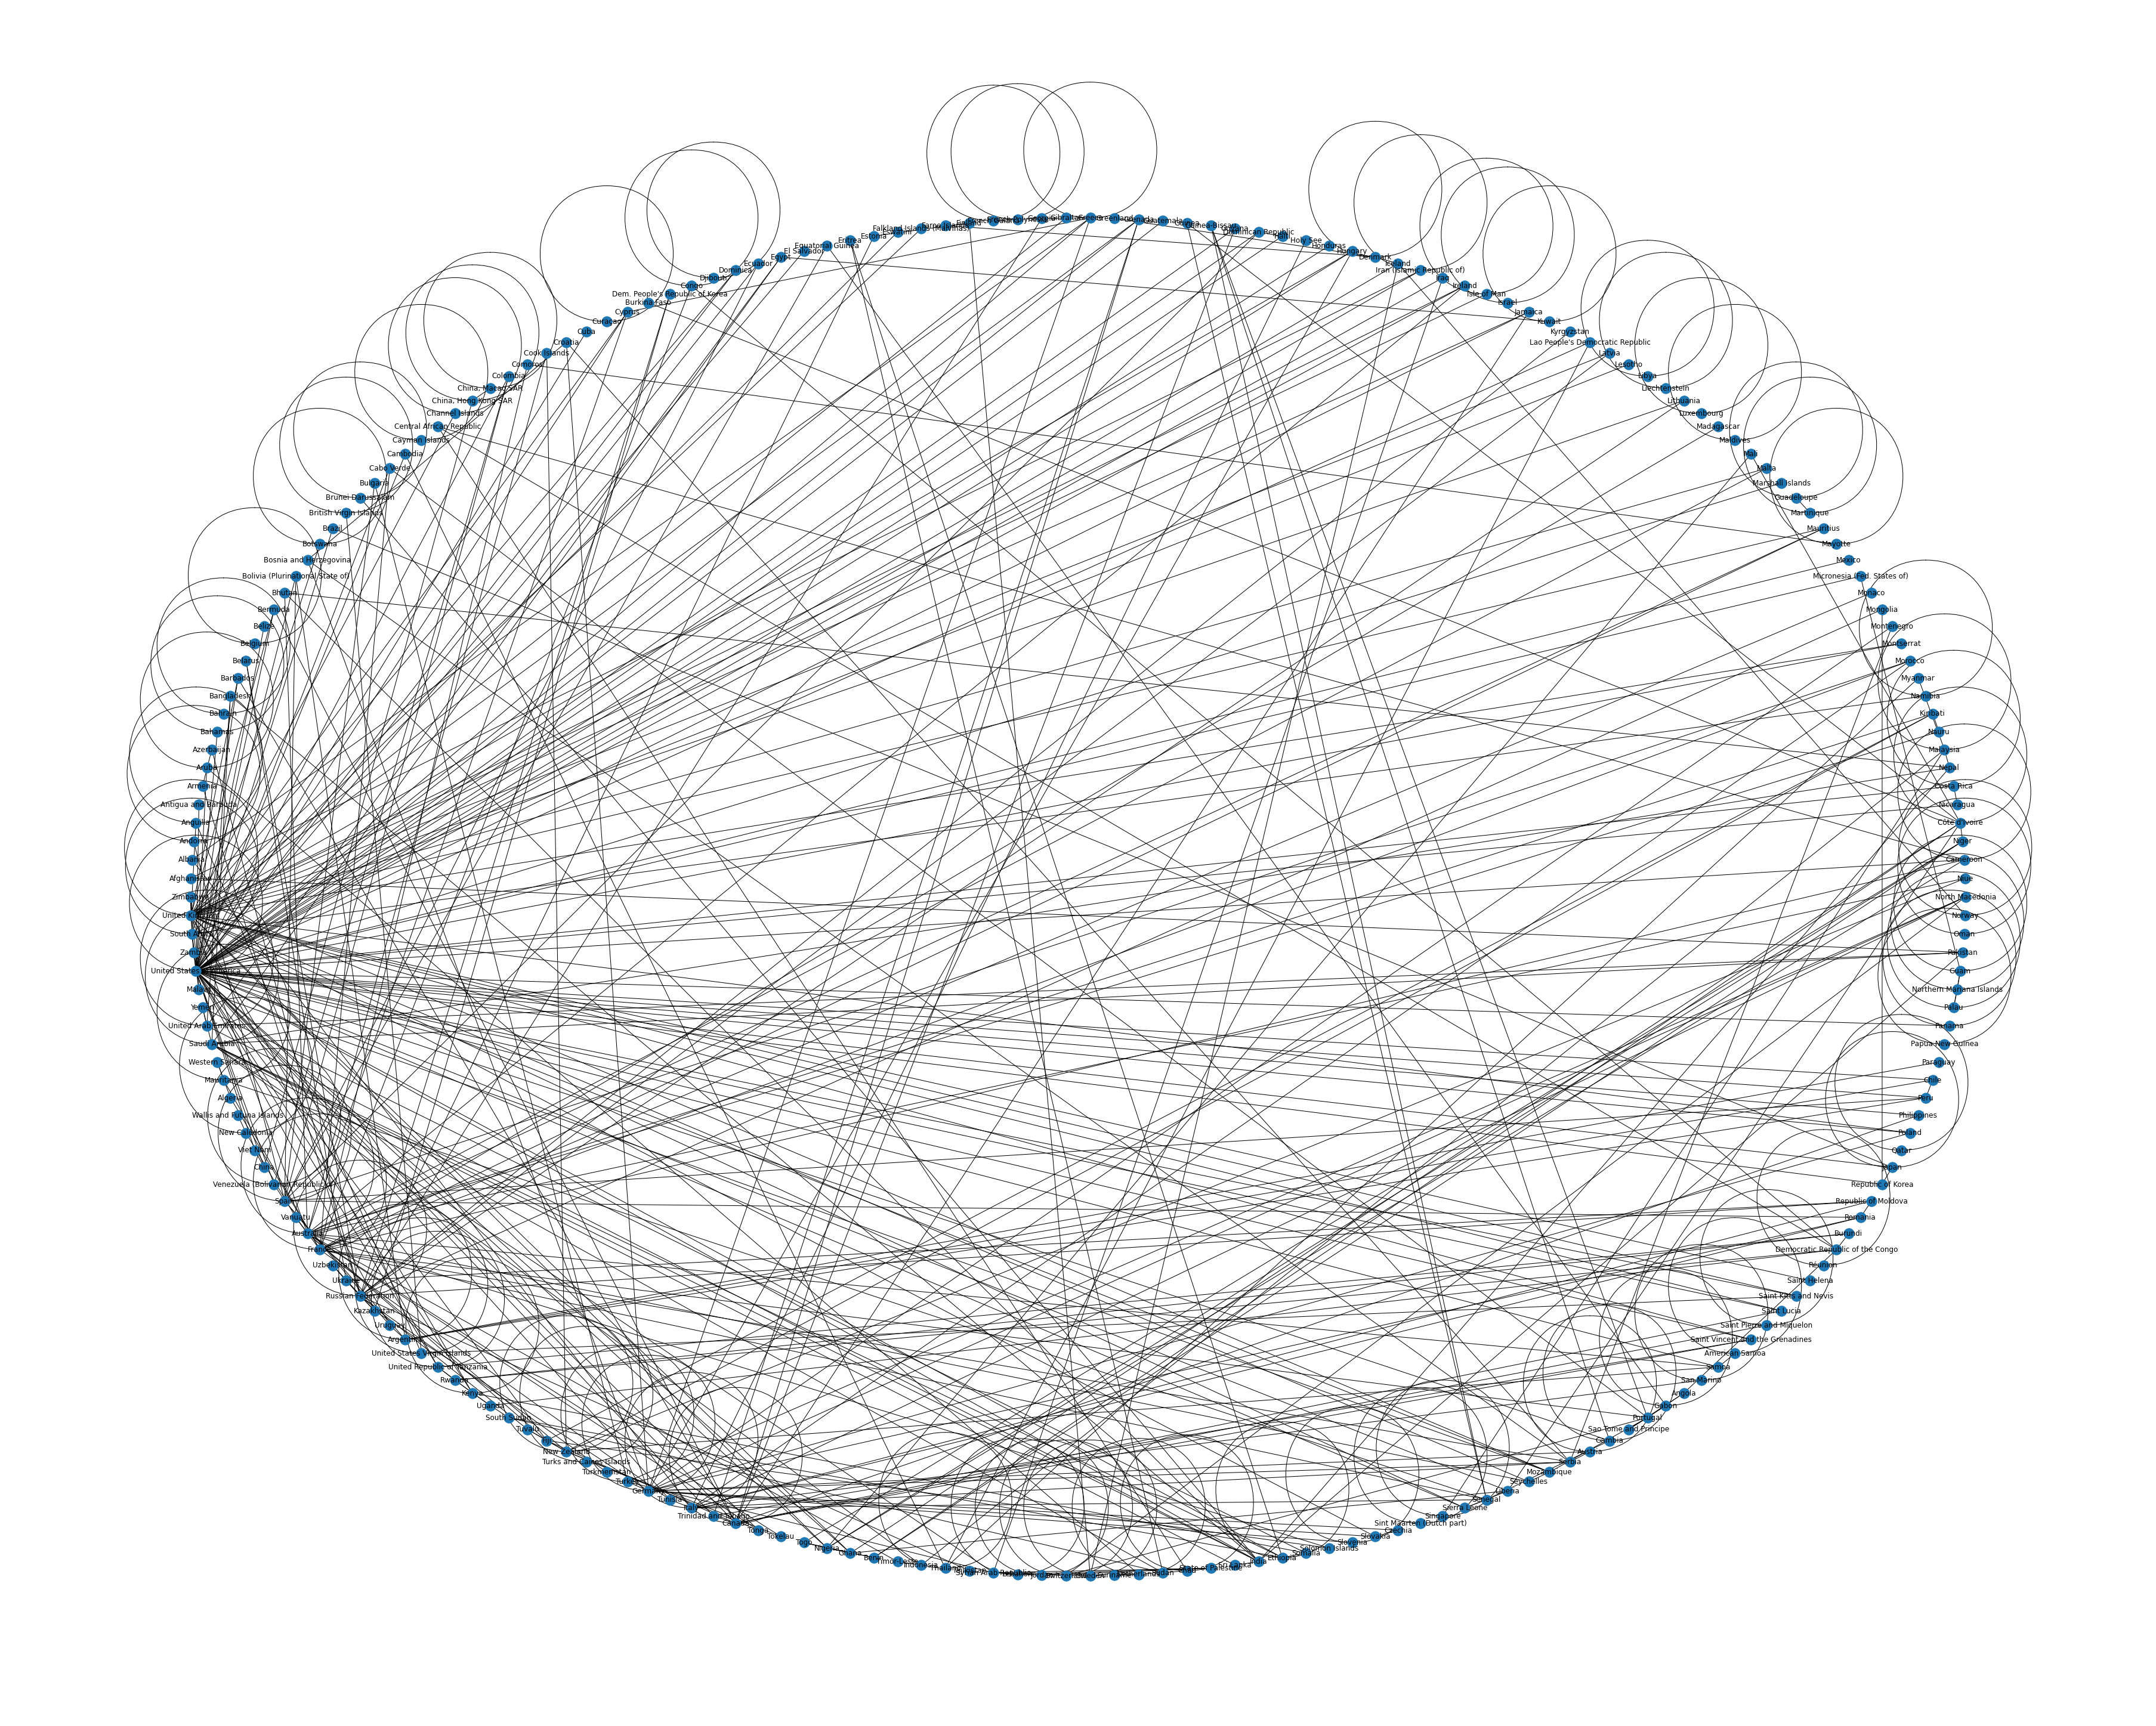

In [41]:
min_weight = 0.1
df_to_newtork = df_migrations_weight[df_migrations_weight['weight'] > min_weight]
# df_to_newtork = df_to_newtork[df_to_newtork['origin'] == 'Brazil']
df1 = df_to_newtork[['origin', 'destination']]
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df1, 'origin', 'destination')
from matplotlib.pyplot import figure
figure(figsize=(50, 40))
nx.draw_shell(G, with_labels=True)

In [42]:
df_migrations_weight[df_migrations_weight['destination'] == 'Brazil'].sort_values(by=['weight'], ascending=False)

origin destination    weight
3434                           Portugal      Brazil  0.081786
418                             Uruguay      Brazil  0.079570
10592  Bolivia (Plurinational State of)      Brazil  0.055057
3757                           Paraguay      Brazil  0.054251
9762                              Chile      Brazil  0.029221
...                                 ...         ...       ...
10874                           Belarus      Brazil  0.000007
5228                               Mali      Brazil  0.000006
855                United Arab Emirates      Brazil  0.000005
4689                            Myanmar      Brazil  0.000005
5887   Lao People's Democratic Republic      Brazil  0.000005

[158 rows x 3 columns]

In [43]:
df_countries = pd.read_csv('countries_list.csv')

In [44]:
df_countries

country
0                      Burundi
1                      Comoros
2                     Djibouti
3                      Eritrea
4                     Ethiopia
..                         ...
230                      Samoa
231                    Tokelau
232                      Tonga
233                     Tuvalu
234  Wallis and Futuna Islands

[235 rows x 1 columns]

In [45]:
flow_matrix = []
migrants_list = []

for idx_origin, country_origin in df_countries.iterrows():
    flow_matrix.append([])
    for idx_destination, country_destination in df_countries.iterrows():
        flow_matrix[idx_origin].append(0.0)
        countries_migration = df_migrations_weight.loc[df_migrations_weight['origin'] == country_origin['country']].loc[df_migrations_weight['destination'] == country_destination['country']]
        if(len(countries_migration) == 0):
            continue
        flow_matrix[idx_origin][idx_destination] = countries_migration['weight'].values[0]
        
flow_matrix = np.array(flow_matrix)
flow_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.83989244, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
migrants_count_list = [] 
migrants_total = df_migrations[year].sum()

for idx, country in df_countries.iterrows(): 
    migrants_in_country = df_migrations.loc[df_migrations[origin_label] == country['country']][year].sum()
    migrants_count_list.append([migrants_in_country/migrants_total])
    
migrants_count_list

[[0.00195687763706618],
 [0.0005179538531871462],
 [7.219081006605954e-05],
 [0.0026578887338347085],
 [0.0035842105437807123],
 [0.0020448050141918393],
 [0.0007481910180150722],
 [0.0012655237469008662],
 [0.000705652511924523],
 [2.7844236659930446e-05],
 [0.0025395858258073062],
 [1.236718043856651e-05],
 [0.0021427384485557203],
 [0.00011692026831548792],
 [0.008544670876868403],
 [0.004512416998010956],
 [0.0033448351940260435],
 [0.0012511910909333635],
 [0.0007843651271547802],
 [0.0049650124084469165],
 [0.0026303678221535638],
 [0.0014846317256168933],
 [0.0029193863189800016],
 [0.0008137111232556511],
 [0.0008713991063127415],
 [0.006688666378907435],
 [0.0004975248196591117],
 [0.0001832529402790686],
 [0.0001495888540009892],
 [0.007812986449875567],
 [0.01340536843689645],
 [0.0006489642837360474],
 [0.012642729897460887],
 [0.007838937533699184],
 [0.003294409260163529],
 [0.0007908061010742812],
 [0.00023523593917099985],
 [0.00019670070683094638],
 [0.0008145109271505

In [47]:
years = 1
migrants_per_year = migrants_count_list
for i in range(0, years):
    migrants_per_year = np.matmul(flow_matrix.transpose(), migrants_per_year)

In [48]:
rank = pd.DataFrame(data={
    'country': df_countries['country'].tolist(), 
    'rank': [item for sublist in migrants_per_year for item in sublist]
})
rank.sort_values(by=['rank'], ascending=False).head(10).reset_index()

index                   country      rank
0    211  United States of America  0.180573
1    116        Russian Federation  0.054463
2    151                   Germany  0.046113
3    103              Saudi Arabia  0.044371
4    131            United Kingdom  0.037580
5    150                    France  0.034668
6    107      United Arab Emirates  0.032555
7    208                    Canada  0.029835
8    139                     Italy  0.027627
9    147                     Spain  0.025203

10 destinos mais cobiçados por imigrantes

Fonte: instituto de pesquisa Gallup World Poll 

10º. Itália. 15 milhões de pessoas

9º. Japão. 17 milhões de pessoas

8º. Espanha. 21 milhões de pessoas

7º. Arábia Saudita. 24 milhões de pessoas

6º. Reino Unido. 34 milhões de pessoas

4º. Austrália. 36 milhões de pessoas

4º. França. 36 milhões de pessoas

3º. Alemanha. 42 milhões de pessoas

2º. Canadá 47 milhões de pessoas

1º. Estados Unidos. 158 milhões de pessoas

Top 10 Countries with the Highest Number of Foreign-Born Residents (Immigrants) - United Nations 2020:

United States — 50.6 million

Germany — 15.8 million

Saudi Arabia — 13.5 million

Russia — 11.6 million

United Kingdom — 9.4 million

United Arab Emirates — 8.7 million

France — 8.5 million

Canada — 8.0 million

Australia — 7.7 million

Spain — 6.8 million

In [49]:
df_rank = rank.sort_values(by=['rank'], ascending=False).reset_index()
df_rank[df_rank['country'] == 'Brazil']

index country      rank
61    195  Brazil  0.002191

In [50]:
# Code to generate Rank by time
# https://towardsdatascience.com/7-visualizations-with-python-to-express-changes-in-rank-over-time-71c1f11d7e4b

# ym = list(set(year_month))
# ym.sort()

# df_month['posi'] = [ym.index(i) for i in df_month['year_month']]
# df_month['CO_str'] = [str(round(i,2)) for i in df_month['CO']]
# df_month['CO_text'] = [str(round(i,2))+' ppm' for i in df_month['CO']]
# df_month.head()

In [51]:
# import plotly.express as px
# fig = px.scatter(df_month, x='posi', y='rank',
#                  size= 'CO',
#                  color='District', text='CO_text',
#                  color_discrete_map= dict_color,
#                  animation_frame='year_month',
#                  animation_group='District',
#                  range_x=[-2,len(ym)],
#                  range_y=[0.5,6.5]
#                 )
# fig.update_xaxes(title='', visible=False)
# fig.update_yaxes(autorange='reversed', title='Rank',
#                  visible=True, showticklabels=True)
# fig.update_layout(xaxis=dict(showgrid=False),
#                   yaxis=dict(showgrid=True))
# fig.update_traces(textposition='middle left')
# fig.show()